In [2]:
import nrrd
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

Visualizing 5 Random Full Slice Images:


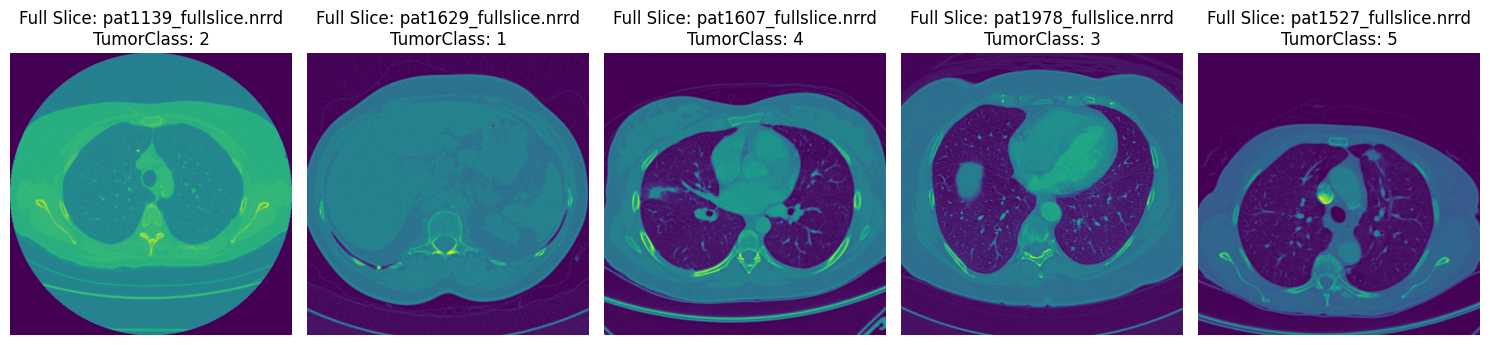

Visualizing 5 Random Nodule Images:


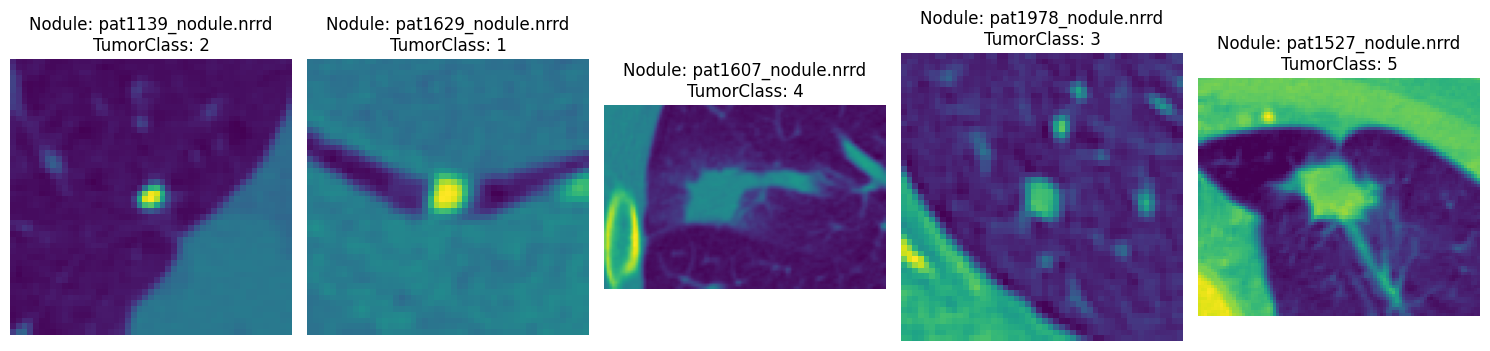

In [3]:
# Define paths
# Path to the folder containing .nrrd files and the .xls file
nrrd_folder = "Train"
xls_file = "dataset_lung.xlsx"

# Load the Excel file
patient_data = pd.read_excel(xls_file)

# Function to visualize a .nrrd file
def visualize_nrrd(nrrd_path, title):
    
    # Read the nrrd file
    data, header = nrrd.read(nrrd_path)
    
    # Check if data is 3D and extract a 2D slice
    if len(data.shape) == 3:
        middle_slice_index = data.shape[0] // 2  # Middle slice
        middle_slice = data[middle_slice_index, :, :]
    elif len(data.shape) == 2:
        middle_slice = data
    else:
        print(f"Unsupported data shape: {data.shape}")
        return
    
    # Plot the slice
    plt.imshow(middle_slice)
    plt.title(title)
    plt.axis("off")

# Function to plot 20 random images for a given column (Full_slice or Nodule)
def plot_random_images(data, image_column, title_prefix):
    # Randomly sample 20 rows
    random_sample = data.sample(n=5, random_state=42)

    # Plot the images
    plt.figure(figsize=(15, 15))
    for idx, (_, row) in enumerate(random_sample.iterrows()):
        image_file = os.path.join(nrrd_folder, row[image_column])
        plt.subplot(4, 5, idx + 1)  # 4 rows x 5 columns
        visualize_nrrd(image_file, f"{title_prefix}: {row[image_column]}\nTumorClass: {row['TumorClass']}")
    plt.tight_layout()
    plt.show()

# Plot Full_slice images
print("Visualizing 5 Random Full Slice Images:")
plot_random_images(patient_data, image_column='Full_slice', title_prefix="Full Slice")

# Plot Nodule images
print("Visualizing 5 Random Nodule Images:")
plot_random_images(patient_data, image_column='Nodule', title_prefix="Nodule")

In [4]:
def load_nrrd(file_path):
    """
    Loads an NRRD file and returns the data and header.
    
    Parameters:
        file_path (str): Path to the .nrrd file.

    Returns:
        tuple: A tuple containing:
            - data (numpy.ndarray): The image data.
            - header (dict): Metadata of the .nrrd file.
    """
    try:
        data, header = nrrd.read(file_path)
        print(f"NRRD file loaded successfully: {file_path}")
        return data, header
    except Exception as e:
        print(f"Error loading NRRD file: {file_path}. Error: {e}")
        return None, None

nrrd_file = "Full_Slices/pat1_fullslice.nrrd"
data, header = load_nrrd(nrrd_file)

if data is not None:
    print("Data shape:", data.shape)
    print("Header info:", header)

NRRD file loaded successfully: Full_Slices/pat1_fullslice.nrrd
Data shape: (512, 512)
Header info: OrderedDict([('type', 'int16'), ('dimension', 2), ('sizes', array([512, 512])), ('endian', 'little'), ('encoding', 'gzip')])


Loaded 2363 images with shape (2363, 512, 512)


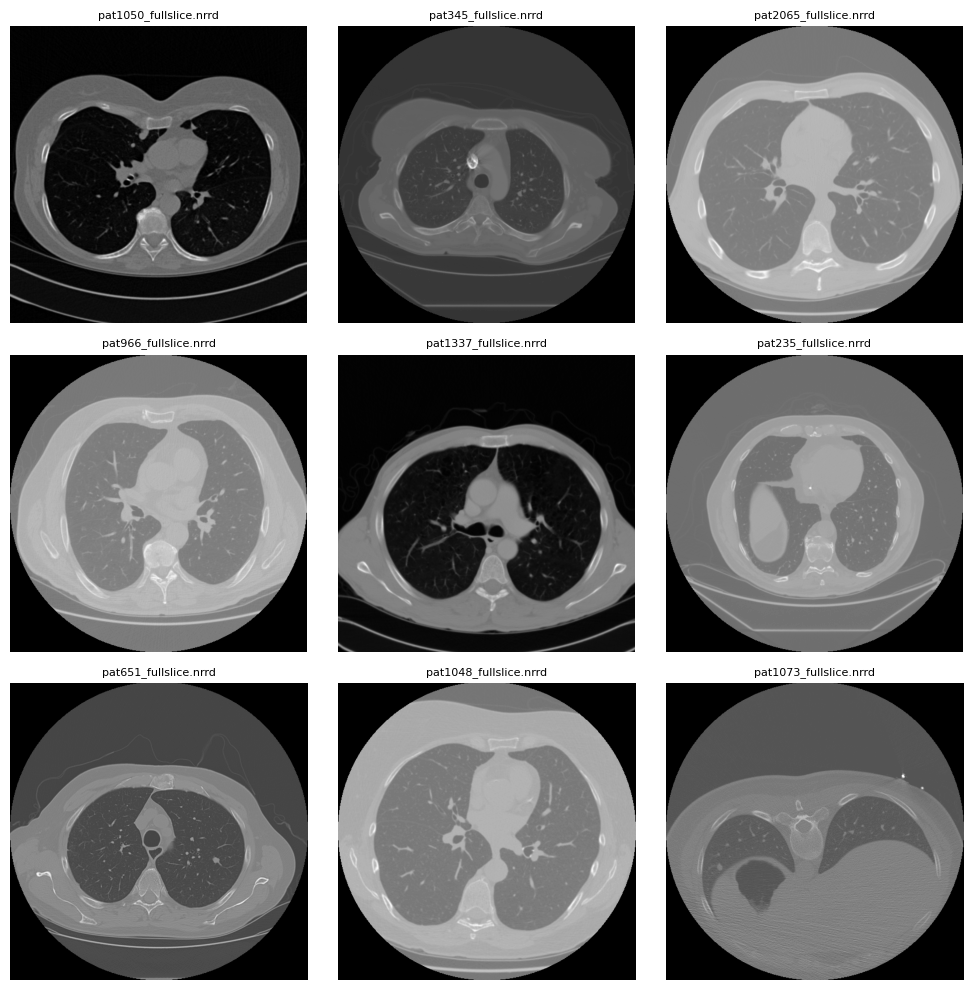

In [5]:
import os
import nrrd
import numpy as np
import matplotlib.pyplot as plt

def load_all_nrrd_images(folder_path):
    """
    Loads all NRRD images from a folder into a single NumPy array.
    
    Parameters:
        folder_path (str): Path to the folder containing .nrrd files.

    Returns:
        numpy.ndarray: Array containing all images, with shape (num_images, height, width).
        list: List of file names corresponding to the images.
    """
    images = []
    file_names = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".nrrd"):
            file_path = os.path.join(folder_path, file_name)
            data, _ = nrrd.read(file_path)
            if len(data.shape) == 3:  # For 3D images, take the middle slice
                    middle_slice = data[data.shape[0] // 2, :, :]
            elif len(data.shape) == 2:  # For 2D images
                    middle_slice = data
            else:
                print(f"Skipping unsupported data shape {data.shape} in {file_name}")
                continue
            images.append(middle_slice)
            file_names.append(file_name)
            

    if images:
        images_array = np.stack(images, axis=0)  # Stack images into a single NumPy array
        print(f"Loaded {len(images)} images with shape {images_array.shape}")
        return images_array, file_names
    else:
        print("No valid NRRD files found.")
        return None, []

def plot_images(images, file_names, num_images=9):
    """
    Plots a specified number of images from the NumPy array.

    Parameters:
        images (numpy.ndarray): Array containing the images (num_images, height, width).
        file_names (list): List of file names corresponding to the images.
        num_images (int): Number of images to plot (default is 9).
    """
    num_images = min(num_images, len(images))
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(int(np.ceil(np.sqrt(num_images))), int(np.ceil(np.sqrt(num_images))), i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(file_names[i], fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
folder_path = "Full_Slices"
images_full_slices, file_names_full_slices = load_all_nrrd_images(folder_path)

plot_images(images_full_slices, file_names_full_slices, num_images=9)

# folder_path = "Nodules"
# images_nodules, file_names_nodules = load_all_nrrd_images(folder_path)

# plot_images(images_nodules, file_names_nodules, num_images=9)


In [14]:
def segment_lungs(ct_scan, lower_bound=-1000, upper_bound=-500):
    """
    Segments the lungs using HU thresholds.
    :param ct_scan: CT scan image in HU (numpy array).
    :param lower_bound: Lower bound in HU for lung tissue.
    :param upper_bound: Upper bound in HU for lung tissue.
    :return: Binary mask (numpy array) of the lungs.
    """
    # Apply the HU thresholds to create a binary mask
    lung_mask = np.logical_and(ct_scan >= lower_bound, ct_scan <= upper_bound)
    segmented_lungs = lung_mask.astype(np.uint8) * 255  # Convert to binary image (0 or 255)
    
    return segmented_lungs


Segmented lung masks array shape: (2363, 512, 512)


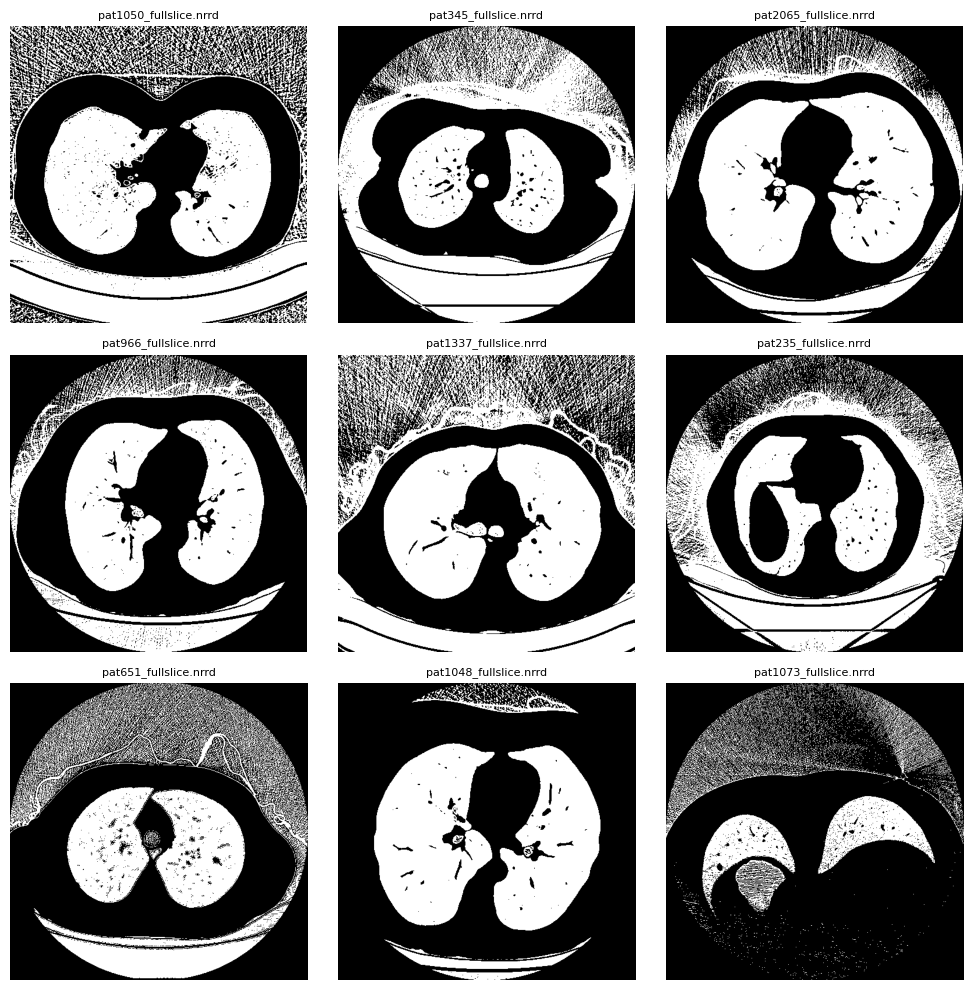

In [15]:
# Array to store the segmented lung masks
segmented_lungs_array = []
    
# Segment lungs for each image and store the result in an array
for i, image in enumerate(images_full_slices):
    segmented_lungs = segment_lungs(image)
    segmented_lungs_array.append(segmented_lungs)


    
# Convert the list of segmented lung masks to a NumPy array
segmented_lungs_array = np.array(segmented_lungs_array)
print(f"Segmented lung masks array shape: {segmented_lungs_array.shape}")
plot_images(segmented_lungs_array, file_names_full_slices, num_images=9)
